Generate 2D ACDC training (+validation)

In [4]:
import ants
import numpy as np

depth = 0

moving_image = np.load(r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task036_Lib\custom_experiment_planner_stage0\patient007_frame01.npz")['data'][0]
fixed_image = np.load(r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task036_Lib\custom_experiment_planner_stage0\patient007_frame01.npz")['data'][0]

moving_image = moving_image[depth]
fixed_image = fixed_image[depth]

moving_image = ants.from_numpy(moving_image)
fixed_image = ants.from_numpy(fixed_image)

registration = ants.registration(
    fixed=fixed_image,
    moving=moving_image,
    type_of_transform='SyN'
)

# Get the deformation field transformation
deformation_field = registration['fwdtransforms'][0]  # Assuming only one transformation is returned

# Load the deformation field image
deformation_field_image = ants.image_read(deformation_field).numpy()

print(deformation_field_image.shape)

transformed_image = ants.apply_transforms(
    fixed=fixed_image,
    moving=moving_image,
    transformlist=registration['fwdtransforms']
)

(409, 431, 2)


In [3]:
import numpy as np
from glob import glob
import os
from tqdm import tqdm
from monai.transforms import ResizeWithPadOrCrop
from pathlib import Path
import shutil
import nibabel as nib
import pickle
from monai.transforms import NormalizeIntensity
import torch
from nnunet.lib.training_utils import read_config
from nnunet.lib.utils import ConvBlocks2D
from nnunet.lib.training_utils import build_2d_model
from nnunet.training.network_training.processor import Processor

def crop_get_padding(arr):
    # 2, H, W, D
    C, H, W, D = arr.shape
    roi_center = [i // 2 for i in [H, W]]

    y1 = max(roi_center[0] - 112, 0)
    y2 = min(roi_center[0] + 112, H)

    x1 = max(roi_center[1] - 112, 0)
    x2 = min(roi_center[1] + 112, W)

    new_arr = arr[:, y1:y2, x1:x2, :]
    padding = ((0, 0), (y1, H - y2), (x1, W - x2), (0, 0))
    
    padded = np.pad(new_arr, padding)
    assert arr.shape == padded.shape

    return new_arr, padding

def delete_if_exist(folder_name):
    dirpath = Path(folder_name)
    if dirpath.exists() and dirpath.is_dir():
        shutil.rmtree(dirpath)

cropper_weights_folder_path = r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\binary"
cropper_config = read_config(os.path.join(Path.cwd(), 'adversarial_acdc.yaml'), False, False)

cropping_conv_layer = ConvBlocks2D
cropping_network = build_2d_model(cropper_config, conv_layer=cropping_conv_layer, norm=getattr(torch.nn, cropper_config['norm']), log_function=None, image_size=224, window_size=7, middle=False, num_classes=2)
cropping_network.load_state_dict(torch.load(os.path.join(cropper_weights_folder_path, 'model_final_checkpoint.model'))['state_dict'], strict=True)
cropping_network.eval()
cropping_network.do_ds = False

processor = Processor(crop_size=128, image_size=224, cropping_network=cropping_network)

output_folder = 'voxelmorph_ACDC_2D'
output_folder_gt = 'voxelmorph_ACDC_gt_2D'

delete_if_exist(output_folder)
Path(output_folder).mkdir(parents=True, exist_ok=True)

delete_if_exist(output_folder_gt)
Path(output_folder_gt).mkdir(parents=True, exist_ok=True)

path_list = sorted(glob(os.path.join(r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task031_ACDC\custom_experiment_planner_stage0", '*.npz')))
path_list_pkl = sorted(glob(os.path.join(r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task031_ACDC\custom_experiment_planner_stage0", '*.pkl')))
#path_list = [x for x in path_list if '_u' not in os.path.basename(x)[:-4]]

assert len(path_list) == len(path_list_pkl)
cropper = ResizeWithPadOrCrop(spatial_size=(224, 224, -1))

patient_list = sorted(list(set([os.path.basename(x).split('_')[0] for x in path_list])))

all_patient_paths = []
all_patient_paths_pkl = []
for patient in patient_list:
    patient_files = []
    patient_files_pkl = []
    for (path, pkl_path) in zip(path_list, path_list_pkl):
        if patient in path:
            patient_files.append(path)
        if patient in pkl_path:
            patient_files_pkl.append(pkl_path)
    all_patient_paths.append(sorted(patient_files))
    all_patient_paths_pkl.append(sorted(patient_files_pkl))

for (path_list, path_list_pkl) in tqdm(zip(all_patient_paths, all_patient_paths_pkl), total=len(all_patient_paths)):

    patient_nb = os.path.basename(path_list[0]).split('_')[0]
    cfg_path = os.path.join('ACDC_training', patient_nb, 'info.cfg')
    with open(cfg_path, 'r') as f:
        lines = f.readlines()
        ed_number = int(lines[0].split(' ')[-1]) - 1
        es_number = int(lines[1].split(' ')[-1]) - 1

    sequence = []
    filename_list = []
    for (npz_path, pkl_path) in zip(path_list, path_list_pkl):
        filename = os.path.basename(npz_path)[:-4] + '.nii.gz'
        data = np.load(npz_path)
        arr = data['data']
        arr = arr.transpose((0, 2, 3, 1))

        initial_shape = list(arr.shape[1:])

        cropped = cropper(arr)
        if cropped.shape[0] == 1:
            cropped = np.tile(cropped, [2, 1, 1, 1])
        sequence.append(cropped)
        filename_list.append(filename)
    sequence = np.stack(sequence, axis=0) # T, C, H, W, D
    sequence = sequence.transpose(4, 0, 1, 2, 3) # D, T, C, H, W

    block = []
    padding_need_list = []
    for d in range(len(sequence)):

        unlabeled = torch.from_numpy(sequence[d]).to('cuda:0')

        with torch.no_grad():
            mean_centroid, _ = processor.preprocess_no_registration(data=torch.clone(unlabeled[:, :1])) # T, C(1), H, W

            cropped_unlabeled, padding_need = processor.crop_and_pad(data=unlabeled, mean_centroid=mean_centroid)
            cropped_unlabeled = cropped_unlabeled.cpu()
            padding_need = padding_need.cpu()
            padding_need_list.append(padding_need)

        block.append(cropped_unlabeled)
    block = np.stack(block, axis=-1) # T, C, H, W, D
    padding_need = np.stack(padding_need_list, axis=-1) # 4, D
    
    #divisor = cropped[0].max() - cropped[0].min()
    #subtrahend = cropped[0].min()
    #cropped_img = NormalizeIntensity(subtrahend=subtrahend, divisor=divisor)(cropped[0])

    for t in range(len(block)):
        current_volume = block[t]
        current_filename = filename_list[t]

        grayscale = current_volume[0]
        grayscale_flattened = grayscale.reshape(-1, current_volume[0].shape[-1])

        if np.any((np.max(grayscale_flattened, axis=0) - np.min(grayscale_flattened, axis=0))) == 0:
            print(current_filename)
            print((np.max(grayscale_flattened, axis=0) - np.min(grayscale_flattened, axis=0)))

        grayscale_flattened = (grayscale_flattened - np.min(grayscale_flattened, axis=0)) / (np.max(grayscale_flattened, axis=0) - np.min(grayscale_flattened, axis=0) + 1e-8)
        grayscale = grayscale_flattened.reshape(current_volume[0].shape)

        nib.save(nib.Nifti1Image(grayscale, affine=np.eye(4)), os.path.join(output_folder, current_filename))
        if '_u' not in current_filename:
            cropped_gt = current_volume[1]
            cropped_gt[cropped_gt < 0] = 0
            nib.save(nib.Nifti1Image(cropped_gt, affine=np.eye(4)), os.path.join(output_folder_gt, current_filename))
        
        with open(path_list_pkl[t], 'rb') as f:
            data = pickle.load(f)
            data['padding_need'] = padding_need
            data['voxelmorph_size_before'] = initial_shape
            data['ed_number'] = ed_number
            data['es_number'] = es_number

            with open(os.path.join(output_folder, os.path.basename(path_list_pkl[t])), 'wb') as f:
                pickle.dump(data, f)

100%|██████████| 100/100 [16:54<00:00, 10.15s/it]


Generate 2D ACDC testing

In [1]:
import numpy as np
from glob import glob
import os
from tqdm import tqdm
from monai.transforms import ResizeWithPadOrCrop
from pathlib import Path
import shutil
import nibabel as nib
import pickle
from monai.transforms import NormalizeIntensity
import torch
from nnunet.lib.training_utils import read_config
from nnunet.lib.utils import ConvBlocks2DGroup
from nnunet.lib.training_utils import build_2d_model
from nnunet.training.network_training.processor import Processor

def delete_if_exist(folder_name):
    dirpath = Path(folder_name)
    if dirpath.exists() and dirpath.is_dir():
        shutil.rmtree(dirpath)

cropper_weights_folder_path = r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\binary"
cropper_config = read_config(os.path.join(Path.cwd(), 'adversarial_acdc.yaml'), False, False)

cropping_conv_layer = ConvBlocks2DGroup
cropping_network = build_2d_model(cropper_config, conv_layer=cropping_conv_layer, norm=getattr(torch.nn, cropper_config['norm']), log_function=None, image_size=224, window_size=7, middle=False, num_classes=2)
cropping_network.load_state_dict(torch.load(os.path.join(cropper_weights_folder_path, 'model_final_checkpoint.model'))['state_dict'], strict=True)
cropping_network.eval()
cropping_network.do_ds = False

processor = Processor(crop_size=128, image_size=224, cropping_network=cropping_network)

output_folder = 'voxelmorph_ACDC_2D_testing'
output_folder_gt = 'voxelmorph_ACDC_gt_2D_testing'

delete_if_exist(output_folder)
Path(output_folder).mkdir(parents=True, exist_ok=True)

delete_if_exist(output_folder_gt)
Path(output_folder_gt).mkdir(parents=True, exist_ok=True)

path_list = sorted(glob(os.path.join(r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task035_ACDC\custom_experiment_planner_stage0", '*.npz')))
path_list_pkl = sorted(glob(os.path.join(r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task035_ACDC\custom_experiment_planner_stage0", '*.pkl')))
#path_list = [x for x in path_list if '_u' not in os.path.basename(x)[:-4]]

assert len(path_list) == len(path_list_pkl)
cropper = ResizeWithPadOrCrop(spatial_size=(224, 224, -1))

patient_list = sorted(list(set([os.path.basename(x).split('_')[0] for x in path_list])))

all_patient_paths = []
all_patient_paths_pkl = []
for patient in patient_list:
    patient_files = []
    patient_files_pkl = []
    for (path, pkl_path) in zip(path_list, path_list_pkl):
        if patient in path:
            patient_files.append(path)
        if patient in pkl_path:
            patient_files_pkl.append(pkl_path)
    all_patient_paths.append(sorted(patient_files))
    all_patient_paths_pkl.append(sorted(patient_files_pkl))

for (path_list, path_list_pkl) in tqdm(zip(all_patient_paths, all_patient_paths_pkl), total=len(all_patient_paths)):

    patient_nb = os.path.basename(path_list[0]).split('_')[0]
    cfg_path = os.path.join('ACDC_testing', patient_nb, 'info.cfg')
    with open(cfg_path, 'r') as f:
        lines = f.readlines()
        ed_number = int(lines[0].split(' ')[-1]) - 1
        es_number = int(lines[1].split(' ')[-1]) - 1

    sequence = []
    filename_list = []
    for (npz_path, pkl_path) in zip(path_list, path_list_pkl):
        filename = os.path.basename(npz_path)[:-4] + '.nii.gz'
        data = np.load(npz_path)
        arr = data['data']
        arr = arr.transpose((0, 2, 3, 1))

        initial_shape = list(arr.shape[1:])

        cropped = cropper(arr)
        if cropped.shape[0] == 1:
            cropped = np.tile(cropped, [2, 1, 1, 1])
        sequence.append(cropped)
        filename_list.append(filename)
    sequence = np.stack(sequence, axis=0) # T, C, H, W, D
    sequence = sequence.transpose(4, 0, 1, 2, 3) # D, T, C, H, W

    block = []
    padding_need_list = []
    for d in range(len(sequence)):

        unlabeled = torch.from_numpy(sequence[d]).to('cuda:0')

        with torch.no_grad():
            mean_centroid, _ = processor.preprocess_no_registration(data=torch.clone(unlabeled[:, :1])) # T, C(1), H, W

            cropped_unlabeled, padding_need = processor.crop_and_pad(data=unlabeled, mean_centroid=mean_centroid)
            cropped_unlabeled = cropped_unlabeled.cpu()
            padding_need = padding_need.cpu()
            padding_need_list.append(padding_need)

        block.append(cropped_unlabeled)
    block = np.stack(block, axis=-1) # T, C, H, W, D
    padding_need = np.stack(padding_need_list, axis=-1) # 4, D
    
    #divisor = cropped[0].max() - cropped[0].min()
    #subtrahend = cropped[0].min()
    #cropped_img = NormalizeIntensity(subtrahend=subtrahend, divisor=divisor)(cropped[0])

    for t in range(len(block)):
        current_volume = block[t]
        current_filename = filename_list[t]

        grayscale = current_volume[0]
        grayscale_flattened = grayscale.reshape(-1, current_volume[0].shape[-1])

        if np.any((np.max(grayscale_flattened, axis=0) - np.min(grayscale_flattened, axis=0))) == 0:
            print(current_filename)
            print((np.max(grayscale_flattened, axis=0) - np.min(grayscale_flattened, axis=0)))

        grayscale_flattened = (grayscale_flattened - np.min(grayscale_flattened, axis=0)) / (np.max(grayscale_flattened, axis=0) - np.min(grayscale_flattened, axis=0) + 1e-8)
        grayscale = grayscale_flattened.reshape(current_volume[0].shape)

        nib.save(nib.Nifti1Image(grayscale, affine=np.eye(4)), os.path.join(output_folder, current_filename))
        if '_u' not in current_filename:
            cropped_gt = current_volume[1]
            cropped_gt[cropped_gt < 0] = 0
            nib.save(nib.Nifti1Image(cropped_gt, affine=np.eye(4)), os.path.join(output_folder_gt, current_filename))
        
        with open(path_list_pkl[t], 'rb') as f:
            data = pickle.load(f)
            data['padding_need'] = padding_need
            data['voxelmorph_size_before'] = initial_shape
            data['ed_number'] = ed_number
            data['es_number'] = es_number

            with open(os.path.join(output_folder, os.path.basename(path_list_pkl[t])), 'wb') as f:
                pickle.dump(data, f)

100%|██████████| 50/50 [07:31<00:00,  9.03s/it]


Generate 2D Lib training (+validation)

In [2]:
%matplotlib qt

import numpy as np
from glob import glob
import os
from tqdm import tqdm
from monai.transforms import ResizeWithPadOrCrop
from pathlib import Path
import shutil
import nibabel as nib
import pickle
from monai.transforms import NormalizeIntensity
import torch
from nnunet.lib.training_utils import read_config
from nnunet.lib.utils import ConvBlocks2DGroup
from nnunet.lib.training_utils import build_2d_model
from nnunet.training.network_training.processor import Processor
import matplotlib.pyplot as plt

def delete_if_exist(folder_name):
    dirpath = Path(folder_name)
    if dirpath.exists() and dirpath.is_dir():
        shutil.rmtree(dirpath)

cropper_weights_folder_path = r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\binary_lib"
cropper_config = read_config(os.path.join(Path.cwd(), 'adversarial_acdc.yaml'), False, False)

cropping_conv_layer = ConvBlocks2DGroup
cropping_network = build_2d_model(cropper_config, conv_layer=cropping_conv_layer, norm=getattr(torch.nn, cropper_config['norm']), log_function=None, image_size=384, window_size=8, middle=False, num_classes=2, processor=None)
cropping_network.load_state_dict(torch.load(os.path.join(cropper_weights_folder_path, 'model_final_checkpoint.model'))['state_dict'], strict=True)
cropping_network.eval()
cropping_network.do_ds = False

processor = Processor(crop_size=192, image_size=384, cropping_network=cropping_network)

output_folder = 'Lib_no_resampling'
output_folder_gt = 'Lib_no_resampling_gt'

delete_if_exist(output_folder)
Path(output_folder).mkdir(parents=True, exist_ok=True)

delete_if_exist(output_folder_gt)
Path(output_folder_gt).mkdir(parents=True, exist_ok=True)

path_list = sorted(glob(os.path.join(r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task045_Lib\custom_experiment_planner_stage0", '*.npz')))
path_list_pkl = sorted(glob(os.path.join(r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task045_Lib\custom_experiment_planner_stage0", '*.pkl')))
#path_list = [x for x in path_list if '_u' not in os.path.basename(x)[:-4]]

assert len(path_list) == len(path_list_pkl)
cropper = ResizeWithPadOrCrop(spatial_size=(384, 384, -1))

patient_list = sorted(list(set([os.path.basename(x).split('_')[0] for x in path_list])))

all_patient_paths = []
all_patient_paths_pkl = []
for patient in patient_list:
    patient_files = []
    patient_files_pkl = []
    for (path, pkl_path) in zip(path_list, path_list_pkl):
        if patient in path:
            patient_files.append(path)
        if patient in pkl_path:
            patient_files_pkl.append(pkl_path)
    all_patient_paths.append(sorted(patient_files))
    all_patient_paths_pkl.append(sorted(patient_files_pkl))

for (path_list, path_list_pkl) in tqdm(zip(all_patient_paths, all_patient_paths_pkl), total=len(all_patient_paths)):
    sequence = []
    filename_list = []
    for (npz_path, pkl_path) in zip(path_list, path_list_pkl):
        filename = os.path.basename(npz_path)[:-4] + '.nii.gz'
        data = np.load(npz_path)
        arr = data['data']
        arr = arr.transpose((0, 2, 3, 1))

        initial_shape = list(arr.shape[1:])

        cropped = cropper(arr)
        if cropped.shape[0] == 1:
            cropped = np.tile(cropped, [2, 1, 1, 1])
        sequence.append(cropped)
        filename_list.append(filename)
    sequence = np.stack(sequence, axis=0) # T, C, H, W, D
    sequence = sequence.transpose(4, 0, 1, 2, 3) # D, T, C, H, W

    block = []
    padding_need_list = []
    for d in range(len(sequence)):

        unlabeled = torch.from_numpy(sequence[d]).to('cuda:0')

        with torch.no_grad():
            mean_centroid, _ = processor.preprocess_no_registration(data=torch.clone(unlabeled[:, :1])) # T, C(1), H, W

            cropped_unlabeled, padding_need = processor.crop_and_pad(data=unlabeled, mean_centroid=mean_centroid)
            cropped_unlabeled = cropped_unlabeled.cpu()
            padding_need = padding_need.cpu()
            padding_need_list.append(padding_need)

        block.append(cropped_unlabeled)
    block = np.stack(block, axis=-1) # T, C, H, W, D
    padding_need = np.stack(padding_need_list, axis=-1) # 4, D
    
    #divisor = cropped[0].max() - cropped[0].min()
    #subtrahend = cropped[0].min()
    #cropped_img = NormalizeIntensity(subtrahend=subtrahend, divisor=divisor)(cropped[0])

    for t in range(len(block)):
        current_volume = block[t]
        current_filename = filename_list[t]

        grayscale = current_volume[0]
        grayscale_flattened = grayscale.reshape(-1, current_volume[0].shape[-1])

        if np.any((np.max(grayscale_flattened, axis=0) - np.min(grayscale_flattened, axis=0))) == 0:
            print(current_filename)
            print((np.max(grayscale_flattened, axis=0) - np.min(grayscale_flattened, axis=0)))

        grayscale_flattened = (grayscale_flattened - np.min(grayscale_flattened, axis=0)) / (np.max(grayscale_flattened, axis=0) - np.min(grayscale_flattened, axis=0) + 1e-8)
        grayscale = grayscale_flattened.reshape(current_volume[0].shape)

        #if t == 36 and '11' in path_list[0]:
        #    fig, ax = plt.subplots(1, 1)
        #    ax.imshow(grayscale[:, :, 0], cmap='gray')
        #    plt.show()
        #    plt.waitforbuttonpress()
        #    plt.close(fig)

        nib.save(nib.Nifti1Image(grayscale, affine=np.eye(4)), os.path.join(output_folder, current_filename))
        if '_u' not in current_filename:
            cropped_gt = current_volume[1]
            cropped_gt[cropped_gt < 0] = 0
            nib.save(nib.Nifti1Image(cropped_gt, affine=np.eye(4)), os.path.join(output_folder_gt, current_filename))
        
        with open(path_list_pkl[t], 'rb') as f:
            data = pickle.load(f)
            data['padding_need'] = padding_need
            data['voxelmorph_size_before'] = initial_shape

            with open(os.path.join(output_folder, os.path.basename(path_list_pkl[t])), 'wb') as f:
                pickle.dump(data, f)

100%|██████████| 220/220 [46:21<00:00, 12.65s/it] 


In [1]:
%matplotlib qt

import numpy as np
from glob import glob
import os
from tqdm import tqdm
from monai.transforms import ResizeWithPadOrCrop
from pathlib import Path
import shutil
import nibabel as nib
import pickle
from monai.transforms import NormalizeIntensity
import torch
from nnunet.lib.training_utils import read_config
from nnunet.lib.utils import ConvBlocks2DGroup
from nnunet.lib.training_utils import build_2d_model
from nnunet.training.network_training.processor2 import Processor2
import matplotlib.pyplot as plt
from skimage import morphology
from skimage import measure

def delete_if_exist(folder_name):
    dirpath = Path(folder_name)
    if dirpath.exists() and dirpath.is_dir():
        shutil.rmtree(dirpath)

#cropper_weights_folder_path = r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\binary_lib"
#cropper_config = read_config(os.path.join(Path.cwd(), 'adversarial_acdc.yaml'), False, False)
#
#cropping_conv_layer = ConvBlocks2DGroup
#cropping_network = build_2d_model(cropper_config, conv_layer=cropping_conv_layer, norm=getattr(torch.nn, cropper_config['norm']), log_function=None, image_size=384, window_size=8, middle=False, num_classes=2, processor=None)
#cropping_network.load_state_dict(torch.load(os.path.join(cropper_weights_folder_path, 'model_final_checkpoint.model'))['state_dict'], strict=True)
#cropping_network.eval()
#cropping_network.do_ds = False

cropper_weights_folder_path = r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\Quorum_cardioTrack_all_phases"
cropper_config = read_config(os.path.join(cropper_weights_folder_path, 'config.yaml'), False, False)

cropping_conv_layer = ConvBlocks2DGroup
cropping_network = build_2d_model(cropper_config, conv_layer=cropping_conv_layer, norm=getattr(torch.nn, cropper_config['norm']), log_function=None, image_size=384, window_size=8, middle=False, num_classes=4, processor=None)
cropping_network.load_state_dict(torch.load(os.path.join(cropper_weights_folder_path, 'model_final_checkpoint.model'))['state_dict'], strict=True)
cropping_network.eval()
cropping_network.do_ds = False

processor = Processor2(crop_size=192, image_size=384, cropping_network=cropping_network)

pretrained_config = read_config(os.path.join(Path.cwd(), '2d_cardiotrack_crop_normalized_2', 'config.yaml'), False, False)
pretrained_conv_layer = ConvBlocks2DGroup
pretrained_network = build_2d_model(pretrained_config, conv_layer=pretrained_conv_layer, norm=getattr(torch.nn, pretrained_config['norm']), log_function=print, image_size=192, window_size=8, middle=False, num_classes=4, processor=None)
pretrained_network.load_state_dict(torch.load(os.path.join('2d_cardiotrack_crop_normalized_2', 'model_final_checkpoint.model'))['state_dict'], strict=True)
pretrained_network.eval()
pretrained_network.do_ds = False

path_list = sorted(glob(os.path.join(r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task045_Lib\custom_experiment_planner_stage0", '*.npz')))
path_list_pkl = sorted(glob(os.path.join(r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task045_Lib\custom_experiment_planner_stage0", '*.pkl')))
#path_list = [x for x in path_list if '_u' not in os.path.basename(x)[:-4]]

assert len(path_list) == len(path_list_pkl)
cropper = ResizeWithPadOrCrop(spatial_size=(384, 384, -1))

patient_list = sorted(list(set([os.path.basename(x).split('_')[0] for x in path_list])))

all_patient_paths = []
all_patient_paths_pkl = []
for patient in patient_list:
    patient_files = []
    patient_files_pkl = []
    for (path, pkl_path) in zip(path_list, path_list_pkl):
        if patient in path:
            patient_files.append(path)
        if patient in pkl_path:
            patient_files_pkl.append(pkl_path)
    all_patient_paths.append(sorted(patient_files))
    all_patient_paths_pkl.append(sorted(patient_files_pkl))

for (path_list, path_list_pkl) in tqdm(zip(all_patient_paths, all_patient_paths_pkl), total=len(all_patient_paths)):
    print(path_list[0])
    if 'patient004' not in path_list[0]:
        continue
    sequence = []
    filename_list = []
    for (npz_path, pkl_path) in zip(path_list, path_list_pkl):
        filename = os.path.basename(npz_path)[:-4] + '.nii.gz'
        data = np.load(npz_path)
        arr = data['data']
        arr = arr.transpose((0, 2, 3, 1))

        initial_shape = list(arr.shape[1:])

        cropped = cropper(arr)
        if cropped.shape[0] == 1:
            cropped = np.tile(cropped, [2, 1, 1, 1])
        sequence.append(cropped)
        filename_list.append(filename)
    sequence = np.stack(sequence, axis=0) # T, C, H, W, D
    sequence = sequence.transpose(4, 0, 1, 2, 3) # D, T, C, H, W

    sequence[:, :, 1][sequence[:, :, 1] < 0] = 0

    block = []
    padding_need_list = []
    for d in range(len(sequence)):

        unlabeled = torch.from_numpy(sequence[d])

        #fig, ax = plt.subplots(1, 1)
        #ax.imshow(unlabeled[0, 1].cpu(), cmap='gray')
        #plt.show()
        #plt.waitforbuttonpress()
        #plt.close(fig)

        with torch.no_grad():
            
            mean_centroid, segmented = processor.preprocess_no_registration(data=torch.clone(unlabeled[:, :1]).to('cuda:0')) # T, C(1), H, W

            strain_mask = processor.get_strain_mask(torch.clone(unlabeled[:, 1]))
            strain_mask = torch.from_numpy(strain_mask)
            strain_mask = strain_mask.permute(3, 0, 1, 2)
            unlabeled = torch.cat([unlabeled, strain_mask], dim=1)
            cropped_unlabeled, padding_need = processor.crop_and_pad(data=unlabeled, mean_centroid=mean_centroid)
            cropped_unlabeled = cropped_unlabeled.cpu()
            padding_need = padding_need.cpu()
            padding_need_list.append(padding_need)

        block.append(cropped_unlabeled)
    block = np.stack(block, axis=-1) # T, C, H, W, D
    padding_need = np.stack(padding_need_list, axis=-1) # 4, D
    
    #divisor = cropped[0].max() - cropped[0].min()
    #subtrahend = cropped[0].min()
    #cropped_img = NormalizeIntensity(subtrahend=subtrahend, divisor=divisor)(cropped[0])

c:\Users\Portal\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/220 [00:00<?, ?it/s]

C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task045_Lib\custom_experiment_planner_stage0\patient001_frame01.npz
C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task045_Lib\custom_experiment_planner_stage0\patient002_frame01.npz
C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task045_Lib\custom_experiment_planner_stage0\patient003_frame01.npz
C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task045_Lib\custom_experiment_planner_stage0\patient004_frame01.npz
bugggggggggggggggggggg2222222222222222
bugggggggggggggggggggg2222222222222222


100%|██████████| 220/220 [01:33<00:00,  2.36it/s]

C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task045_Lib\custom_experiment_planner_stage0\patient005_frame01.npz
C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task045_Lib\custom_experiment_planner_stage0\patient006_frame01.npz
C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task045_Lib\custom_experiment_planner_stage0\patient008_frame01.npz
C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task045_Lib\custom_experiment_planner_stage0\patient009_frame01.npz
C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task045_Lib\custom_experiment_planner_stage0\patient010_frame01.npz
C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task045_Lib\custom_experiment_planner_stage0\patient011_frame01.npz
C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task045_Lib\custom_experiment_planner_stage0\patient012_frame01.npz
C:\Users\Portal\Docu

(3, 249, 244)


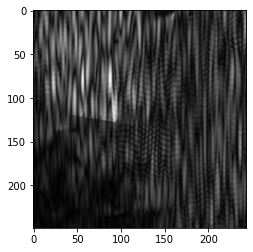

In [5]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load(r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task045_Lib\custom_experiment_planner_stage0\patient021_frame01.npy")[0]
print(data.shape)

fig, ax = plt.subplots(1, 1)
ax.imshow(data[1], cmap='gray')

In [2]:
%matplotlib qt

import numpy as np
from glob import glob
import os
from tqdm import tqdm
from monai.transforms import ResizeWithPadOrCrop
from pathlib import Path
import shutil
import nibabel as nib
import pickle
from monai.transforms import NormalizeIntensity
import torch
from nnunet.lib.training_utils import read_config
from nnunet.lib.utils import ConvBlocks2DGroup
from nnunet.lib.training_utils import build_2d_model
from nnunet.training.network_training.processor2 import Processor2
import matplotlib.pyplot as plt

def delete_if_exist(folder_name):
    dirpath = Path(folder_name)
    if dirpath.exists() and dirpath.is_dir():
        shutil.rmtree(dirpath)

#cropper_weights_folder_path = r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\binary_lib"
#cropper_config = read_config(os.path.join(Path.cwd(), 'adversarial_acdc.yaml'), False, False)
#
#cropping_conv_layer = ConvBlocks2DGroup
#cropping_network = build_2d_model(cropper_config, conv_layer=cropping_conv_layer, norm=getattr(torch.nn, cropper_config['norm']), log_function=None, image_size=384, window_size=8, middle=False, num_classes=2, processor=None)
#cropping_network.load_state_dict(torch.load(os.path.join(cropper_weights_folder_path, 'model_final_checkpoint.model'))['state_dict'], strict=True)
#cropping_network.eval()
#cropping_network.do_ds = False

cropper_weights_folder_path = r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\Quorum_cardioTrack_all_phases"
cropper_config = read_config(os.path.join(cropper_weights_folder_path, 'config.yaml'), False, False)

cropping_conv_layer = ConvBlocks2DGroup
cropping_network = build_2d_model(cropper_config, conv_layer=cropping_conv_layer, norm=getattr(torch.nn, cropper_config['norm']), log_function=None, image_size=384, window_size=8, middle=False, num_classes=4, processor=None)
cropping_network.load_state_dict(torch.load(os.path.join(cropper_weights_folder_path, 'model_final_checkpoint.model'))['state_dict'], strict=True)
cropping_network.eval()
cropping_network.do_ds = False

processor = Processor2(crop_size=192, image_size=384, cropping_network=cropping_network)

pretrained_config = read_config(os.path.join(Path.cwd(), '2d_cardiotrack_crop_normalized_2', 'config.yaml'), False, False)
pretrained_conv_layer = ConvBlocks2DGroup
pretrained_network = build_2d_model(pretrained_config, conv_layer=pretrained_conv_layer, norm=getattr(torch.nn, pretrained_config['norm']), log_function=print, image_size=192, window_size=8, middle=False, num_classes=4, processor=None)
pretrained_network.load_state_dict(torch.load(os.path.join('2d_cardiotrack_crop_normalized_2', 'model_final_checkpoint.model'))['state_dict'], strict=True)
pretrained_network.eval()
pretrained_network.do_ds = False

output_folder = 'Lib_resampling_training_mask'

delete_if_exist(output_folder)
Path(output_folder).mkdir(parents=True, exist_ok=True)

path_list = sorted(glob(os.path.join(r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task032_Lib\custom_experiment_planner_stage0", '*.npz')))
path_list_pkl = sorted(glob(os.path.join(r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task032_Lib\custom_experiment_planner_stage0", '*.pkl')))
#path_list = [x for x in path_list if '_u' not in os.path.basename(x)[:-4]]

assert len(path_list) == len(path_list_pkl)
cropper = ResizeWithPadOrCrop(spatial_size=(384, 384, -1))

patient_list = sorted(list(set([os.path.basename(x).split('_')[0] for x in path_list])))

all_patient_paths = []
all_patient_paths_pkl = []
for patient in patient_list:
    patient_files = []
    patient_files_pkl = []
    for (path, pkl_path) in zip(path_list, path_list_pkl):
        if patient in path:
            patient_files.append(path)
        if patient in pkl_path:
            patient_files_pkl.append(pkl_path)
    all_patient_paths.append(sorted(patient_files))
    all_patient_paths_pkl.append(sorted(patient_files_pkl))

for (path_list, path_list_pkl) in tqdm(zip(all_patient_paths, all_patient_paths_pkl), total=len(all_patient_paths)):
    sequence = []
    filename_list = []
    for (npz_path, pkl_path) in zip(path_list, path_list_pkl):
        filename = os.path.basename(npz_path)[:-4] + '.nii.gz'
        data = np.load(npz_path)
        arr = data['data']
        arr = arr.transpose((0, 2, 3, 1))

        initial_shape = list(arr.shape[1:])

        cropped = cropper(arr)
        if cropped.shape[0] == 1:
            cropped = np.tile(cropped, [2, 1, 1, 1])
        sequence.append(cropped)
        filename_list.append(filename)
    sequence = np.stack(sequence, axis=0) # T, C, H, W, D
    sequence = sequence.transpose(4, 0, 1, 2, 3) # D, T, C, H, W

    sequence[:, :, 1][sequence[:, :, 1] < 0] = 0

    block = []
    padding_need_list = []
    for d in range(len(sequence)):

        unlabeled = torch.from_numpy(sequence[d])

        #if unlabeled[0, 0].std() > 1000:
        #    print(unlabeled[0, 0].std())
        #    continue

        with torch.no_grad():
            mean_centroid, _ = processor.preprocess_no_registration(data=torch.clone(unlabeled[:, :1]).to('cuda:0')) # T, C(1), H, W

            strain_mask = processor.get_strain_mask_3(torch.clone(unlabeled[:, 1]), path_list[0])
            strain_mask = torch.from_numpy(strain_mask)
            strain_mask = strain_mask.permute(3, 0, 1, 2)
            unlabeled = torch.cat([unlabeled, strain_mask], dim=1)
            cropped_unlabeled, padding_need = processor.crop_and_pad(data=unlabeled, mean_centroid=mean_centroid)
            cropped_unlabeled = cropped_unlabeled.cpu()
            padding_need = padding_need.cpu()
            padding_need_list.append(padding_need)

        block.append(cropped_unlabeled)
    block = np.stack(block, axis=-1) # T, C, H, W, D
    padding_need = np.stack(padding_need_list, axis=-1) # 4, D
    
    #divisor = cropped[0].max() - cropped[0].min()
    #subtrahend = cropped[0].min()
    #cropped_img = NormalizeIntensity(subtrahend=subtrahend, divisor=divisor)(cropped[0])

    for t in range(len(block)):
        current_volume = block[t]
        current_filename = filename_list[t]

        grayscale = current_volume[0]
        grayscale_flattened = grayscale.reshape(-1, current_volume[0].shape[-1])

        if np.any((np.max(grayscale_flattened, axis=0) - np.min(grayscale_flattened, axis=0))) == 0:
            print(current_filename)
            print((np.max(grayscale_flattened, axis=0) - np.min(grayscale_flattened, axis=0)))

        grayscale_flattened = (grayscale_flattened - np.min(grayscale_flattened, axis=0)) / (np.max(grayscale_flattened, axis=0) - np.min(grayscale_flattened, axis=0) + 1e-8)
        grayscale = grayscale_flattened.reshape(current_volume[0].shape)

        #if t == 36 and '11' in path_list[0]:
        #    fig, ax = plt.subplots(1, 1)
        #    ax.imshow(grayscale[:, :, 0], cmap='gray')
        #    plt.show()
        #    plt.waitforbuttonpress()
        #    plt.close(fig)

        cropped_gt = current_volume[1]
        cropped_gt[cropped_gt < 0] = 0

        out = np.concatenate([grayscale[None], cropped_gt[None], current_volume[2:]], axis=0)
        #fig, ax = plt.subplots(1,3)
        #ax[0].imshow(current_volume[2, :, :, 1], cmap='gray')
        #ax[1].imshow(current_volume[3, :, :, 1], cmap='gray')
        #ax[2].imshow(current_volume[4, :, :, 1], cmap='gray')
        #plt.show()
        #plt.waitforbuttonpress()
        #plt.close(fig)

        np.save(os.path.join(output_folder, current_filename[:-7] + '.npy'), out)
        #nib.save(nib.Nifti1Image(out_block, affine=np.eye(4)), os.path.join(output_folder_mask, current_filename))
        
        with open(path_list_pkl[t], 'rb') as f:
            data = pickle.load(f)
            data['padding_need'] = padding_need
            data['voxelmorph_size_before'] = initial_shape

            with open(os.path.join(output_folder, os.path.basename(path_list_pkl[t])), 'wb') as f:
                pickle.dump(data, f)

100%|██████████| 220/220 [1:28:09<00:00, 24.04s/it]


In [11]:
path_list = glob(os.path.join(r'out\nnUNet_preprocessed\Task045_Lib\custom_experiment_planner_stage0', '*.npy'))
for path in tqdm(path_list):
    data = np.load(path)[0]
    for d in range(len(data)):
        if data[d].std() > 800:
            print(d)
            print(data[d].std())
            print(path)
            fig, ax = plt.subplots(1, 1)
            ax.imshow(data[d], cmap='gray')
            plt.waitforbuttonpress()
            

  9%|▉         | 728/8157 [00:02<00:29, 247.95it/s]

1
2210.185
out\nnUNet_preprocessed\Task045_Lib\custom_experiment_planner_stage0\patient021_frame01.npy


  9%|▉         | 761/8157 [00:06<04:04, 30.28it/s] 

1
3373.2751
out\nnUNet_preprocessed\Task045_Lib\custom_experiment_planner_stage0\patient021_frame02.npy


100%|██████████| 8157/8157 [00:39<00:00, 208.79it/s]


In [6]:
%matplotlib qt

import numpy as np
import matplotlib.pyplot as plt

data = np.load(r'Lib_no_resampling_training_mask\patient021_frame01.npy')[0]
print(data.shape)
fig, ax = plt.subplots(1, 1)
ax.imshow(data[:, :, 2], cmap='gray')
plt.waitforbuttonpress()

(192, 192, 3)


KeyboardInterrupt: 

In [1]:
%matplotlib qt

import numpy as np
from glob import glob
import os
from tqdm import tqdm
from monai.transforms import ResizeWithPadOrCrop
from pathlib import Path
import shutil
import nibabel as nib
import pickle
from monai.transforms import NormalizeIntensity
import torch
from nnunet.lib.training_utils import read_config
from nnunet.lib.utils import ConvBlocks2DGroup
from nnunet.lib.training_utils import build_2d_model
from nnunet.training.network_training.processor2 import Processor2
import matplotlib.pyplot as plt

def delete_if_exist(folder_name):
    dirpath = Path(folder_name)
    if dirpath.exists() and dirpath.is_dir():
        shutil.rmtree(dirpath)

cropper_weights_folder_path = r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\Quorum_cardioTrack_all_phases"
cropper_config = read_config(os.path.join(cropper_weights_folder_path, 'config.yaml'), False, False)

cropping_conv_layer = ConvBlocks2DGroup
cropping_network = build_2d_model(cropper_config, conv_layer=cropping_conv_layer, norm=getattr(torch.nn, cropper_config['norm']), log_function=None, image_size=384, window_size=8, middle=False, num_classes=4, processor=None)
cropping_network.load_state_dict(torch.load(os.path.join(cropper_weights_folder_path, 'model_final_checkpoint.model'))['state_dict'], strict=True)
cropping_network.eval()
cropping_network.do_ds = False

processor = Processor2(crop_size=192, image_size=384, cropping_network=cropping_network)

pretrained_config = read_config(os.path.join(Path.cwd(), '2d_cardiotrack_crop_normalized_2', 'config.yaml'), False, False)
pretrained_conv_layer = ConvBlocks2DGroup
pretrained_network = build_2d_model(pretrained_config, conv_layer=pretrained_conv_layer, norm=getattr(torch.nn, pretrained_config['norm']), log_function=print, image_size=192, window_size=8, middle=False, num_classes=4, processor=None)
pretrained_network.load_state_dict(torch.load(os.path.join('2d_cardiotrack_crop_normalized_2', 'model_final_checkpoint.model'))['state_dict'], strict=True)
pretrained_network.eval()
pretrained_network.do_ds = False

output_folder = 'Lib_resampling_testing_mask_2'

delete_if_exist(output_folder)
Path(output_folder).mkdir(parents=True, exist_ok=True)

path_list = sorted(glob(os.path.join(r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task036_Lib\custom_experiment_planner_stage0", '*.npz')))
path_list_pkl = sorted(glob(os.path.join(r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task036_Lib\custom_experiment_planner_stage0", '*.pkl')))
#path_list = [x for x in path_list if '_u' not in os.path.basename(x)[:-4]]

assert len(path_list) == len(path_list_pkl)
cropper = ResizeWithPadOrCrop(spatial_size=(384, 384, -1))

patient_list = sorted(list(set([os.path.basename(x).split('_')[0] for x in path_list])))

all_patient_paths = []
all_patient_paths_pkl = []
for patient in patient_list:
    patient_files = []
    patient_files_pkl = []
    for (path, pkl_path) in zip(path_list, path_list_pkl):
        if patient in path:
            patient_files.append(path)
        if patient in pkl_path:
            patient_files_pkl.append(pkl_path)
    all_patient_paths.append(sorted(patient_files))
    all_patient_paths_pkl.append(sorted(patient_files_pkl))

for (path_list, path_list_pkl) in tqdm(zip(all_patient_paths, all_patient_paths_pkl), total=len(all_patient_paths)):
    if 'patient166' not in path_list[0]:
        continue
    
    sequence = []
    filename_list = []
    for (npz_path, pkl_path) in zip(path_list, path_list_pkl):
        filename = os.path.basename(npz_path)[:-4] + '.nii.gz'
        data = np.load(npz_path)
        arr = data['data']
        arr = arr.transpose((0, 2, 3, 1))

        initial_shape = list(arr.shape[1:])

        cropped = cropper(arr)
        if cropped.shape[0] == 1:
            cropped = np.tile(cropped, [2, 1, 1, 1])
        sequence.append(cropped)
        filename_list.append(filename)
    sequence = np.stack(sequence, axis=0) # T, C, H, W, D
    sequence = sequence.transpose(4, 0, 1, 2, 3) # D, T, C, H, W

    sequence[:, :, 1][sequence[:, :, 1] < 0] = 0

    block = []
    padding_need_list = []
    for d in range(len(sequence)):
        print(d)

        unlabeled = torch.from_numpy(sequence[d])

        with torch.no_grad():
            mean_centroid, _ = processor.preprocess_no_registration(data=torch.clone(unlabeled[:, :1]).to('cuda:0')) # T, C(1), H, W

            strain_mask = processor.get_strain_mask_3(torch.clone(unlabeled[:, 1]), path_list[0])
            strain_mask = torch.from_numpy(strain_mask)
            strain_mask = strain_mask.permute(3, 0, 1, 2)
            unlabeled = torch.cat([unlabeled, strain_mask], dim=1)
            cropped_unlabeled, padding_need = processor.crop_and_pad(data=unlabeled, mean_centroid=mean_centroid)
            cropped_unlabeled = cropped_unlabeled.cpu()
            padding_need = padding_need.cpu()
            padding_need_list.append(padding_need)

        block.append(cropped_unlabeled)
    block = np.stack(block, axis=-1) # T, C, H, W, D
    padding_need = np.stack(padding_need_list, axis=-1) # 4, D

c:\Users\Portal\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/51 [00:00<?, ?it/s]

0


 59%|█████▉    | 30/51 [01:45<01:14,  3.53s/it]


KeyboardInterrupt: 

Testing

In [1]:
%matplotlib qt

import numpy as np
from glob import glob
import os
from tqdm import tqdm
from monai.transforms import ResizeWithPadOrCrop
from pathlib import Path
import shutil
import nibabel as nib
import pickle
from monai.transforms import NormalizeIntensity
import torch
from nnunet.lib.training_utils import read_config
from nnunet.lib.utils import ConvBlocks2DGroup
from nnunet.lib.training_utils import build_2d_model
from nnunet.training.network_training.processor2 import Processor2
import matplotlib.pyplot as plt

def delete_if_exist(folder_name):
    dirpath = Path(folder_name)
    if dirpath.exists() and dirpath.is_dir():
        shutil.rmtree(dirpath)

cropper_weights_folder_path = r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\Quorum_cardioTrack_all_phases"
cropper_config = read_config(os.path.join(cropper_weights_folder_path, 'config.yaml'), False, False)

cropping_conv_layer = ConvBlocks2DGroup
cropping_network = build_2d_model(cropper_config, conv_layer=cropping_conv_layer, norm=getattr(torch.nn, cropper_config['norm']), log_function=None, image_size=384, window_size=8, middle=False, num_classes=4, processor=None)
cropping_network.load_state_dict(torch.load(os.path.join(cropper_weights_folder_path, 'model_final_checkpoint.model'))['state_dict'], strict=True)
cropping_network.eval()
cropping_network.do_ds = False

processor = Processor2(crop_size=192, image_size=384, cropping_network=cropping_network)

pretrained_config = read_config(os.path.join(Path.cwd(), '2d_cardiotrack_crop_normalized_2', 'config.yaml'), False, False)
pretrained_conv_layer = ConvBlocks2DGroup
pretrained_network = build_2d_model(pretrained_config, conv_layer=pretrained_conv_layer, norm=getattr(torch.nn, pretrained_config['norm']), log_function=print, image_size=192, window_size=8, middle=False, num_classes=4, processor=None)
pretrained_network.load_state_dict(torch.load(os.path.join('2d_cardiotrack_crop_normalized_2', 'model_final_checkpoint.model'))['state_dict'], strict=True)
pretrained_network.eval()
pretrained_network.do_ds = False

output_folder = 'Lib_resampling_testing_mask'

delete_if_exist(output_folder)
Path(output_folder).mkdir(parents=True, exist_ok=True)

path_list = sorted(glob(os.path.join(r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task036_Lib\custom_experiment_planner_stage0", '*.npz')))
path_list_pkl = sorted(glob(os.path.join(r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task036_Lib\custom_experiment_planner_stage0", '*.pkl')))
#path_list = [x for x in path_list if '_u' not in os.path.basename(x)[:-4]]

assert len(path_list) == len(path_list_pkl)
cropper = ResizeWithPadOrCrop(spatial_size=(384, 384, -1))

patient_list = sorted(list(set([os.path.basename(x).split('_')[0] for x in path_list])))

all_patient_paths = []
all_patient_paths_pkl = []
for patient in patient_list:
    patient_files = []
    patient_files_pkl = []
    for (path, pkl_path) in zip(path_list, path_list_pkl):
        if patient in path:
            patient_files.append(path)
        if patient in pkl_path:
            patient_files_pkl.append(pkl_path)
    all_patient_paths.append(sorted(patient_files))
    all_patient_paths_pkl.append(sorted(patient_files_pkl))

for (path_list, path_list_pkl) in tqdm(zip(all_patient_paths, all_patient_paths_pkl), total=len(all_patient_paths)):
    sequence = []
    filename_list = []
    for (npz_path, pkl_path) in zip(path_list, path_list_pkl):
        filename = os.path.basename(npz_path)[:-4] + '.nii.gz'
        data = np.load(npz_path)
        arr = data['data']
        arr = arr.transpose((0, 2, 3, 1))

        initial_shape = list(arr.shape[1:])

        cropped = cropper(arr)
        if cropped.shape[0] == 1:
            cropped = np.tile(cropped, [2, 1, 1, 1])
        sequence.append(cropped)
        filename_list.append(filename)
    sequence = np.stack(sequence, axis=0) # T, C, H, W, D
    sequence = sequence.transpose(4, 0, 1, 2, 3) # D, T, C, H, W

    sequence[:, :, 1][sequence[:, :, 1] < 0] = 0

    block = []
    padding_need_list = []
    for d in range(len(sequence)):

        unlabeled = torch.from_numpy(sequence[d])

        with torch.no_grad():
            mean_centroid, _ = processor.preprocess_no_registration(data=torch.clone(unlabeled[:, :1]).to('cuda:0')) # T, C(1), H, W

            strain_mask = processor.get_strain_mask_3(torch.clone(unlabeled[:, 1]), path_list[0])
            strain_mask = torch.from_numpy(strain_mask)
            strain_mask = strain_mask.permute(3, 0, 1, 2)
            unlabeled = torch.cat([unlabeled, strain_mask], dim=1)
            cropped_unlabeled, padding_need = processor.crop_and_pad(data=unlabeled, mean_centroid=mean_centroid)
            cropped_unlabeled = cropped_unlabeled.cpu()
            padding_need = padding_need.cpu()
            padding_need_list.append(padding_need)

        block.append(cropped_unlabeled)
    block = np.stack(block, axis=-1) # T, C, H, W, D
    padding_need = np.stack(padding_need_list, axis=-1) # 4, D
    
    #divisor = cropped[0].max() - cropped[0].min()
    #subtrahend = cropped[0].min()
    #cropped_img = NormalizeIntensity(subtrahend=subtrahend, divisor=divisor)(cropped[0])

    for t in range(len(block)):
        current_volume = block[t]
        current_filename = filename_list[t]

        grayscale = current_volume[0]
        grayscale_flattened = grayscale.reshape(-1, current_volume[0].shape[-1])

        if np.any((np.max(grayscale_flattened, axis=0) - np.min(grayscale_flattened, axis=0))) == 0:
            print(current_filename)
            print((np.max(grayscale_flattened, axis=0) - np.min(grayscale_flattened, axis=0)))

        grayscale_flattened = (grayscale_flattened - np.min(grayscale_flattened, axis=0)) / (np.max(grayscale_flattened, axis=0) - np.min(grayscale_flattened, axis=0) + 1e-8)
        grayscale = grayscale_flattened.reshape(current_volume[0].shape)

        


        #if t == 36 and '11' in path_list[0]:
        #    fig, ax = plt.subplots(1, 1)
        #    ax.imshow(grayscale[:, :, 0], cmap='gray')
        #    plt.show()
        #    plt.waitforbuttonpress()
        #    plt.close(fig)

        cropped_gt = current_volume[1]
        cropped_gt[cropped_gt < 0] = 0

        out = np.concatenate([grayscale[None], cropped_gt[None], current_volume[2:]], axis=0)
        #fig, ax = plt.subplots(1,3)
        #ax[0].imshow(current_volume[2, :, :, 1], cmap='gray')
        #ax[1].imshow(current_volume[3, :, :, 1], cmap='gray')
        #ax[2].imshow(current_volume[4, :, :, 1], cmap='gray')
        #plt.show()
        #plt.waitforbuttonpress()
        #plt.close(fig)

        np.save(os.path.join(output_folder, current_filename[:-7] + '.npy'), out)
        #nib.save(nib.Nifti1Image(out_block, affine=np.eye(4)), os.path.join(output_folder_mask, current_filename))
        
        with open(path_list_pkl[t], 'rb') as f:
            data = pickle.load(f)
            data['padding_need'] = padding_need
            data['voxelmorph_size_before'] = initial_shape

            with open(os.path.join(output_folder, os.path.basename(path_list_pkl[t])), 'wb') as f:
                pickle.dump(data, f)

c:\Users\Portal\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 51/51 [19:34<00:00, 23.02s/it]


Generate 2D Lib testing

In [3]:
%matplotlib qt

import numpy as np
from glob import glob
import os
from tqdm import tqdm
from monai.transforms import ResizeWithPadOrCrop
from pathlib import Path
import shutil
import nibabel as nib
import pickle
from monai.transforms import NormalizeIntensity
import torch
from nnunet.lib.training_utils import read_config
from nnunet.lib.utils import ConvBlocks2DGroup
from nnunet.lib.training_utils import build_2d_model
from nnunet.training.network_training.processor import Processor
import matplotlib.pyplot as plt

def delete_if_exist(folder_name):
    dirpath = Path(folder_name)
    if dirpath.exists() and dirpath.is_dir():
        shutil.rmtree(dirpath)

cropper_weights_folder_path = r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\binary_lib"
cropper_config = read_config(os.path.join(Path.cwd(), 'adversarial_acdc.yaml'), False, False)

cropping_conv_layer = ConvBlocks2DGroup
cropping_network = build_2d_model(cropper_config, conv_layer=cropping_conv_layer, norm=getattr(torch.nn, cropper_config['norm']), log_function=None, image_size=384, window_size=8, middle=False, num_classes=2, processor=None)
cropping_network.load_state_dict(torch.load(os.path.join(cropper_weights_folder_path, 'model_final_checkpoint.model'))['state_dict'], strict=True)
cropping_network.eval()
cropping_network.do_ds = False

processor = Processor(crop_size=192, image_size=384, cropping_network=cropping_network)

output_folder = 'Lib_no_resampling_testing'
output_folder_gt = 'Lib_no_resampling_gt_testing'

delete_if_exist(output_folder)
Path(output_folder).mkdir(parents=True, exist_ok=True)

delete_if_exist(output_folder_gt)
Path(output_folder_gt).mkdir(parents=True, exist_ok=True)

path_list = sorted(glob(os.path.join(r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task046_Lib\custom_experiment_planner_stage0", '*.npz')))
path_list_pkl = sorted(glob(os.path.join(r"C:\Users\Portal\Documents\Isensee\nnUNet\nnunet\out\nnUNet_preprocessed\Task046_Lib\custom_experiment_planner_stage0", '*.pkl')))
#path_list = [x for x in path_list if '_u' not in os.path.basename(x)[:-4]]

assert len(path_list) == len(path_list_pkl)
cropper = ResizeWithPadOrCrop(spatial_size=(384, 384, -1))

patient_list = sorted(list(set([os.path.basename(x).split('_')[0] for x in path_list])))

all_patient_paths = []
all_patient_paths_pkl = []
for patient in patient_list:
    patient_files = []
    patient_files_pkl = []
    for (path, pkl_path) in zip(path_list, path_list_pkl):
        if patient in path:
            patient_files.append(path)
        if patient in pkl_path:
            patient_files_pkl.append(pkl_path)
    all_patient_paths.append(sorted(patient_files))
    all_patient_paths_pkl.append(sorted(patient_files_pkl))

for (path_list, path_list_pkl) in tqdm(zip(all_patient_paths, all_patient_paths_pkl), total=len(all_patient_paths)):
    sequence = []
    filename_list = []
    for (npz_path, pkl_path) in zip(path_list, path_list_pkl):
        filename = os.path.basename(npz_path)[:-4] + '.nii.gz'
        data = np.load(npz_path)
        arr = data['data']
        arr = arr.transpose((0, 2, 3, 1))

        initial_shape = list(arr.shape[1:])

        cropped = cropper(arr)
        if cropped.shape[0] == 1:
            cropped = np.tile(cropped, [2, 1, 1, 1])
        sequence.append(cropped)
        filename_list.append(filename)
    sequence = np.stack(sequence, axis=0) # T, C, H, W, D
    sequence = sequence.transpose(4, 0, 1, 2, 3) # D, T, C, H, W

    block = []
    padding_need_list = []
    for d in range(len(sequence)):

        unlabeled = torch.from_numpy(sequence[d]).to('cuda:0')

        with torch.no_grad():
            mean_centroid, _ = processor.preprocess_no_registration(data=torch.clone(unlabeled[:, :1])) # T, C(1), H, W

            cropped_unlabeled, padding_need = processor.crop_and_pad(data=unlabeled, mean_centroid=mean_centroid)
            cropped_unlabeled = cropped_unlabeled.cpu()
            padding_need = padding_need.cpu()
            padding_need_list.append(padding_need)

        block.append(cropped_unlabeled)
    block = np.stack(block, axis=-1) # T, C, H, W, D
    padding_need = np.stack(padding_need_list, axis=-1) # 4, D
    
    #divisor = cropped[0].max() - cropped[0].min()
    #subtrahend = cropped[0].min()
    #cropped_img = NormalizeIntensity(subtrahend=subtrahend, divisor=divisor)(cropped[0])

    for t in range(len(block)):
        current_volume = block[t]
        current_filename = filename_list[t]

        grayscale = current_volume[0]
        grayscale_flattened = grayscale.reshape(-1, current_volume[0].shape[-1])

        if np.any((np.max(grayscale_flattened, axis=0) - np.min(grayscale_flattened, axis=0))) == 0:
            print(current_filename)
            print((np.max(grayscale_flattened, axis=0) - np.min(grayscale_flattened, axis=0)))

        grayscale_flattened = (grayscale_flattened - np.min(grayscale_flattened, axis=0)) / (np.max(grayscale_flattened, axis=0) - np.min(grayscale_flattened, axis=0) + 1e-8)
        grayscale = grayscale_flattened.reshape(current_volume[0].shape)

        #if t == 36 and '11' in path_list[0]:
        #    fig, ax = plt.subplots(1, 1)
        #    ax.imshow(grayscale[:, :, 0], cmap='gray')
        #    plt.show()
        #    plt.waitforbuttonpress()
        #    plt.close(fig)

        nib.save(nib.Nifti1Image(grayscale, affine=np.eye(4)), os.path.join(output_folder, current_filename))
        if '_u' not in current_filename:
            cropped_gt = current_volume[1]
            cropped_gt[cropped_gt < 0] = 0
            nib.save(nib.Nifti1Image(cropped_gt, affine=np.eye(4)), os.path.join(output_folder_gt, current_filename))
        
        with open(path_list_pkl[t], 'rb') as f:
            data = pickle.load(f)
            data['padding_need'] = padding_need
            data['voxelmorph_size_before'] = initial_shape

            with open(os.path.join(output_folder, os.path.basename(path_list_pkl[t])), 'wb') as f:
                pickle.dump(data, f)

100%|██████████| 51/51 [10:24<00:00, 12.25s/it]
